# 0. Data selection and necessary package importing
We select the SPDR Gold Shares (GLD) ETF as the gold ETF.

Similarly, we choose the SPDR Portfolio Europe ETF (SPEU) as the equity ETF.

The currency for Bitcoin is USD.


In [2]:
#IMPORT NECESSARY PACKAGES
import arch
import holidays
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_coint_rank
%matplotlib inline
import yfinance as yf

# 1.Data importing and pre-processing

In [3]:
start=datetime(2020,1,1)
end=datetime(2020,12,31)

In [4]:
btc_df=yf.download('BTC-USD', start, end)
gold_df=yf.download('GLD', start, end)
eqty_df=yf.download('SPEU', start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
btc_df.shape

(362, 6)

In [6]:
gold_df.shape

(253, 6)

In [7]:
eqty_df.shape

(253, 6)

We have to ensure that all three datasets have data for same and equal number of days to make cointegration operation in part 7 apply properly.

In [8]:
missing = set(btc_df.index).symmetric_difference(set(gold_df.index))
def remove_missing_days(df, indices, missing):
    return df.loc[[index for index in indices if index not in missing]]

In [9]:
gold_df = remove_missing_days(gold_df, eqty_df.index, missing)
eqty_df = remove_missing_days(eqty_df, eqty_df.index, missing)
btc_df = remove_missing_days(btc_df, eqty_df.index, missing)
#to confirm
assert eqty_df.shape == gold_df.shape
assert eqty_df.shape == btc_df.shape

In [10]:
#to remove and unnecessary data point
gold_df=gold_df['2020-1-2':]
eqty_df=eqty_df['2020-1-2':]
btc_df=btc_df['2020-1-2':]


In [11]:
gold_df.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02  143.860001  144.210007  143.399994  143.949997  143.949997   
2020-01-03  145.750000  146.320007  145.399994  145.860001  145.860001   
2020-01-06  148.440002  148.479996  146.949997  147.389999  147.389999   
2020-01-07  147.570007  148.139999  147.429993  147.970001  147.970001   
2020-01-08  148.490005  148.610001  146.139999  146.860001  146.860001   

              Volume  
Date                  
2020-01-02   7733800  
2020-01-03  12272800  
2020-01-06  14403300  
2020-01-07   7978500  
2020-01-08  22248500

In [12]:
gold_df.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-12-23  175.100006  176.210007  175.059998  175.649994  175.649994   
2020-12-24  175.550003  176.369995  175.509995  176.350006  176.350006   
2020-12-28  177.259995  177.910004  175.630005  175.710007  175.710007   
2020-12-29  176.250000  176.970001  175.570007  176.350006  176.350006   
2020-12-30  176.440002  177.720001  176.440002  177.699997  177.699997   

             Volume  
Date                 
2020-12-23  6542800  
2020-12-24  3695400  
2020-12-28  7778700  
2020-12-29  5983700  
2020-12-30  5914000

In [13]:
btc_df.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-02  7202.551270  7212.155273  6935.270020  6985.470215  6985.470215   
2020-01-03  6984.428711  7413.715332  6914.996094  7344.884277  7344.884277   
2020-01-06  7410.452148  7781.867188  7409.292969  7769.219238  7769.219238   
2020-01-07  7768.682129  8178.215820  7768.227539  8163.692383  8163.692383   
2020-01-08  8161.935547  8396.738281  7956.774414  8079.862793  8079.862793   

                 Volume  
Date                     
2020-01-02  20802083465  
2020-01-03  28111481032  
2020-01-06  23276261598  
2020-01-07  28767291327  
2020-01-08  31672559265

In [14]:
btc_df.tail()

Open          High           Low         Close  \
Date                                                                 
2020-12-23  23781.974609  24024.490234  22802.646484  23241.345703   
2020-12-24  23240.203125  23768.337891  22777.597656  23735.949219   
2020-12-28  26280.822266  27389.111328  26207.640625  27084.808594   
2020-12-29  27081.810547  27370.720703  25987.298828  27362.437500   
2020-12-30  27360.089844  28937.740234  27360.089844  28840.953125   

               Adj Close       Volume  
Date                                   
2020-12-23  23241.345703  51146161904  
2020-12-24  23735.949219  41080759713  
2020-12-28  27084.808594  49056742893  
2020-12-29  27362.437500  45265946774  
2020-12-30  28840.953125  51287442704

In [15]:
eqty_df.head()

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2020-01-02  36.650002  36.790001  36.619999  36.750000  35.156544    8300
2020-01-03  36.250000  36.520000  36.250000  36.320000  34.745190   23200
2020-01-06  36.189999  36.470001  36.189999  36.470001  34.888687   17200
2020-01-07  36.290001  36.310001  36.250000  36.259998  34.687786   43300
2020-01-08  36.220001  36.430000  36.220001  36.360001  34.783451   13000

In [16]:
eqty_df.tail()

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2020-12-23  37.410000  37.500000  37.250000  37.400002  36.800678  540400
2020-12-24  37.500000  37.599998  37.340000  37.439999  36.840038   26600
2020-12-28  37.889999  38.029999  37.720001  37.810001  37.204109   56500
2020-12-29  38.220001  38.279999  37.939999  37.970001  37.361546   72700
2020-12-30  38.189999  38.330002  38.000000  38.060001  37.450104   26700

# 2. Data Processing

We use adjusted close prices to calculate the daily returns. Adjusted close prices are the prices that already take into account stock split and dividends, which reflex more accurate the change of the prices.

In [17]:
eqty_df["Daily Return"] = eqty_df["Adj Close"].pct_change(1)
eqty_df.loc['2020-4-1':].head()

Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2020-04-01  26.020000  26.320000  25.709999  25.809999  24.906504   15600   
2020-04-02  25.980000  26.280001  25.820000  26.209999  25.292501   29800   
2020-04-03  25.900000  26.120001  25.530001  25.660000  24.761751   26400   
2020-04-06  26.530001  27.049999  26.530001  27.049999  26.103096   23100   
2020-04-07  27.840000  27.840000  27.150000  27.200001  26.247845   50700   

            Daily Return  
Date                      
2020-04-01     -0.041945  
2020-04-02      0.015498  
2020-04-03     -0.020984  
2020-04-06      0.054170  
2020-04-07      0.005545

In [18]:
gold_df["Daily Return"] = gold_df["Adj Close"].pct_change(1)
gold_df.loc['2020-4-1':].head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-04-01  148.199997  150.080002  147.850006  149.449997  149.449997   
2020-04-02  151.199997  152.500000  150.699997  151.899994  151.899994   
2020-04-03  152.229996  153.089996  151.660004  152.649994  152.649994   
2020-04-06  154.160004  157.220001  153.960007  156.880005  156.880005   
2020-04-07  155.330002  156.139999  154.380005  156.039993  156.039993   

              Volume  Daily Return  
Date                                
2020-04-01  11827400      0.009456  
2020-04-02   9188300      0.016393  
2020-04-03   8469100      0.004937  
2020-04-06  14739300      0.027711  
2020-04-07   9195400     -0.005354

In [19]:
btc_df["Daily Return"] = btc_df["Adj Close"].pct_change(1)
btc_df.loc['2020-4-1':].head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-04-01  6437.319336  6612.573730  6202.373535  6606.776367  6606.776367   
2020-04-02  6606.776367  7088.247559  6595.918457  6793.624512  6793.624512   
2020-04-03  6797.396484  7003.220703  6673.335938  6733.387207  6733.387207   
2020-04-06  6788.049805  7271.781250  6782.889648  7271.781250  7271.781250   
2020-04-07  7273.644043  7427.939453  7136.714355  7176.414551  7176.414551   

                 Volume  Daily Return  
Date                                   
2020-04-01  40346426266      0.026113  
2020-04-02  47660646124      0.028281  
2020-04-03  38976504903     -0.008867  
2020-04-06  46896904615      0.079959  
2020-04-07  44243482668     -0.013115

# 3. Data Summaries

In [20]:
df_names = {0: "gold ETF", 1: "equity ETF", 2: "Bitcoin"}
dfs = [gold_df, eqty_df, btc_df]
def get_data(df, month_start, month_end, column=None):
    data = df[(df.index >= f"2020-{month_start:02d}-01") & (df.index < f"2020-{month_end:02d}-01")]
    if column: 
        data = data[column]
    return data

In [21]:
def summarize_data(df):
    data = get_data(df, 3, 12, "Adj Close")
    moving_avg = data.rolling(20, min_periods=1).mean()
    return get_data(moving_avg, 4, 12)

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Moving average for gold ETF from April to December


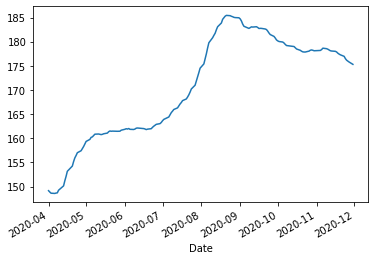

Date
2020-04-01    149.164499
2020-04-02    148.884998
2020-04-03    148.639998
2020-04-06    148.593498
2020-04-07    148.671498
Name: Adj Close, dtype: float64
Date
2020-11-23    176.975001
2020-11-24    176.503500
2020-11-25    176.172500
2020-11-27    175.792000
2020-11-30    175.315500
Name: Adj Close, dtype: float64
------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Moving average for equity ETF from April to December


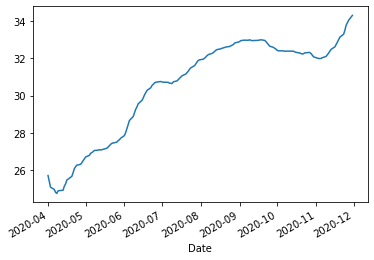

Date
2020-04-01    25.701951
2020-04-02    25.390510
2020-04-03    25.074535
2020-04-06    24.952860
2020-04-07    24.801114
Name: Adj Close, dtype: float64
Date
2020-11-23    33.299154
2020-11-24    33.507487
2020-11-25    33.777441
2020-11-27    34.051307
2020-11-30    34.310990
Name: Adj Close, dtype: float64
------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Moving average for Bitcoin from April to December


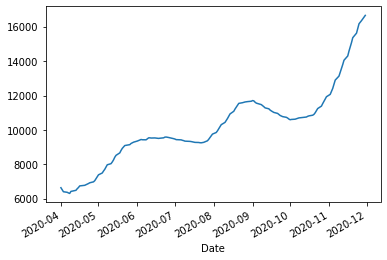

Date
2020-04-01    6642.140503
2020-04-02    6527.883594
2020-04-03    6408.425659
2020-04-06    6375.832495
2020-04-07    6339.166748
Name: Adj Close, dtype: float64
Date
2020-11-23    15628.844727
2020-11-24    15901.507031
2020-11-25    16174.548828
2020-11-27    16358.074805
2020-11-30    16662.040479
Name: Adj Close, dtype: float64


In [22]:
moving_avgs = []
for index, df in enumerate(dfs):
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"Moving average for {df_names[index]} from April to December")
    data = summarize_data(df)
    data.plot()
    plt.show()
    print(data.head())
    print(data.tail())
    moving_avgs.append(data)

# 4. Graphing

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices and its moving averages for gold ETF from April to December


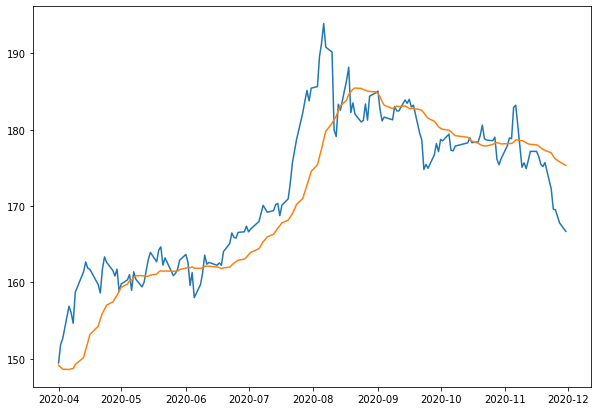

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices and its moving averages for equity ETF from April to December


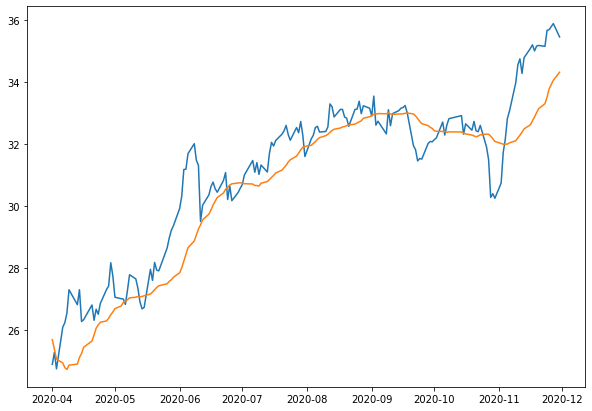

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices and its moving averages for Bitcoin from April to December


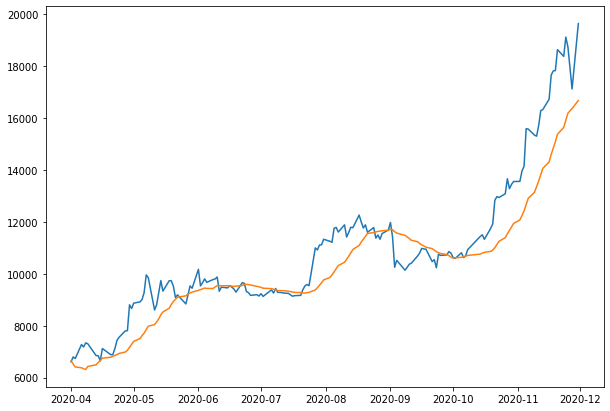

In [23]:
for index, df in enumerate(dfs):
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"The prices and its moving averages for {df_names[index]} from April to December")
    data = get_data(df, 4, 12, "Adj Close")
    moving_avg = moving_avgs[index]
    plt.figure(figsize=(10,7))
    plt.plot(data)
    plt.plot(moving_avg)
    plt.show()

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices of gold ETF and equity ETF from April to December


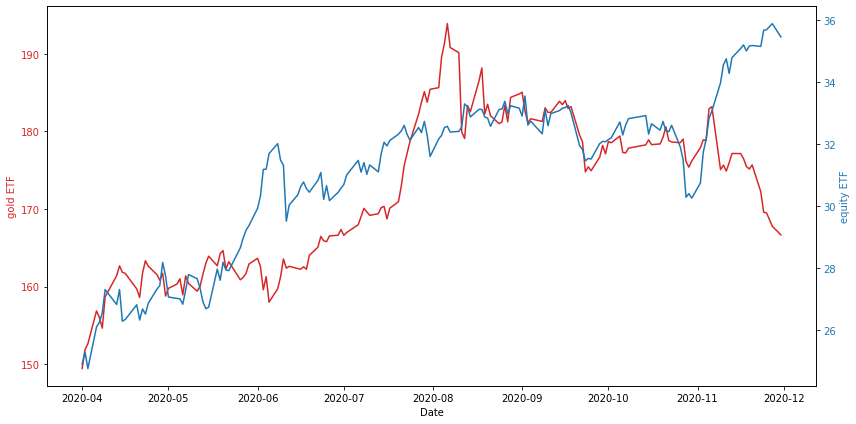

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices of gold ETF and Bitcoin from April to December


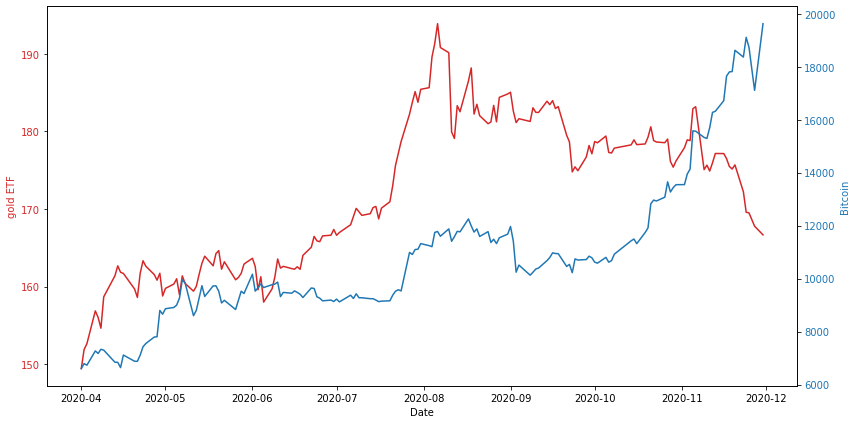

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices of equity ETF and Bitcoin from April to December


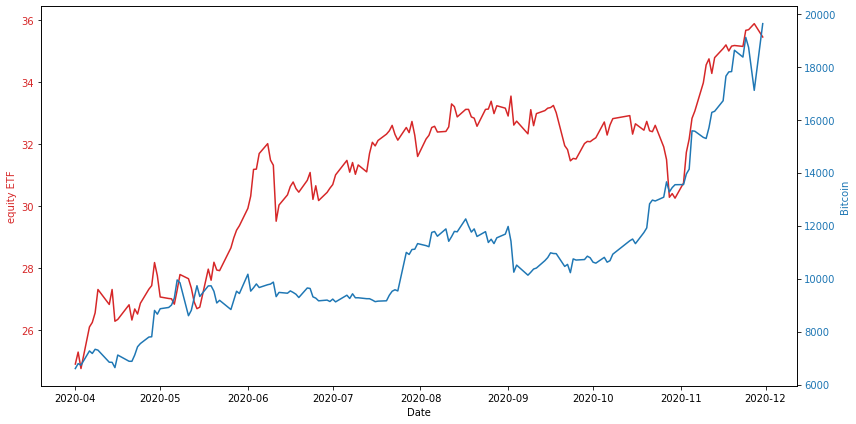

In [24]:
for i, j in [(0, 1), (0, 2), (1, 2)]:
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"The prices of {df_names[i]} and {df_names[j]} from April to December")
    y1_data = get_data(dfs[i], 4, 12, "Adj Close")
    y2_data = get_data(dfs[j], 4, 12, "Adj Close")
    fig, y1_axis = plt.subplots(figsize=(12,6))

    y1_color = 'tab:red'
    y2_color = 'tab:blue'

    y1_axis.set_xlabel('Date')
    y1_axis.set_ylabel(df_names[i], color=y1_color)
    y1_axis.plot( y1_data, color=y1_color)
    y1_axis.tick_params(axis='y', labelcolor=y1_color)
    y2_axis = y1_axis.twinx() 


    y2_axis.set_ylabel(df_names[j], color=y2_color)  
    y2_axis.plot( y2_data, color=y2_color)
    y2_axis.tick_params(axis='y', labelcolor=y2_color)

    fig.tight_layout()  
    plt.show()

# 5. Fitting a GARCH

In [25]:
def get_data(df, month_start, month_end, column):
    return df[(df.index >= f"2020-{month_start:02d}-01") & (df.index < f"2020-{month_end:02d}-01")][column]

In [26]:
def fit_garch(data, garch_type="GARCH"):
    if garch_type == "TARCH":
        garch = arch.arch_model(data, vol='GARCH', p=1, o=1, q=1, power=1)
    else:
        garch = arch.arch_model(data, vol=garch_type, p=1, o=0, q=1)
    garch_fitted = garch.fit()
    print(garch_fitted.summary())
    if garch_type != "FIGARCH":
        omega = garch_fitted.params["omega"]
        alpha = garch_fitted.params["alpha[1]"]
        beta = garch_fitted.params["beta[1]"]
        print(f"Unconditional variance: {omega/(1 - alpha - beta)}")

In [27]:
for model in ["GARCH", "EGARCH", "FIGARCH", "TARCH"]:
    index = 1
    df = dfs[index]
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"{model} model for {df_names[index]} from April to December")
    data = get_data(df, 4, 12, "Daily Return")
    data = data.dropna()
    fit_garch(data, model)

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
GARCH model for equity ETF from April to December
Iteration:      1,   Func. Count:      6,   Neg. LLF: -460.8285880040824
Iteration:      2,   Func. Count:     18,   Neg. LLF: -460.86134182980965
Iteration:      3,   Func. Count:     31,   Neg. LLF: -460.8613534736791
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -460.8613542311274
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           Daily Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Lik

C:\anaconda\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002335. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\anaconda\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002335. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:

Iteration:      6,   Func. Count:     55,   Neg. LLF: -462.15609336285013
Iteration:      7,   Func. Count:     63,   Neg. LLF: -462.19101091006644
Iteration:      8,   Func. Count:     70,   Neg. LLF: -462.2896307854088
Iteration:      9,   Func. Count:     77,   Neg. LLF: -462.3016571165625
Iteration:     10,   Func. Count:     84,   Neg. LLF: -462.30397362057863
Iteration:     11,   Func. Count:     97,   Neg. LLF: -462.304345966299
Iteration:     12,   Func. Count:    108,   Neg. LLF: -462.3048990200406
Iteration:     13,   Func. Count:    118,   Neg. LLF: -462.3049028384411
Iteration:     14,   Func. Count:    128,   Neg. LLF: -462.3049203883794
Iteration:     15,   Func. Count:    138,   Neg. LLF: -462.3050664104935
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -462.30506673413964
            Iterations: 16
            Function evaluations: 142
            Gradient evaluations: 15
                  Constant Mean - TARCH/ZARCH Model Res

# 6. Assessing Stationarity

Use Augmented Dickey-Fuller test with regression = "c" to test for stationary

In [28]:
for index, df in enumerate(dfs):
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"Test stationary for {df_names[index]} from April to December")
    X = get_data(df, 4, 12, "Daily Return").values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Test stationary for gold ETF from April to December
ADF Statistic: -12.523970
p-value: 0.000000
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576
------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Test stationary for equity ETF from April to December
ADF Statistic: -7.736753
p-value: 0.000000
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576
------------------------------------------------------------------------------
------------------------------------------------------------------------------
-------------------------------------------------------------------

For all these time series, we can reject the null hypothesis that there is a unit root in the time series and the time series are stationary.

# 7. Modelling Cointegration

In [29]:
data1 = get_data(gold_df, 4, 9, "Daily Return").values
data2 = get_data(eqty_df, 4, 9, "Daily Return").values
data3 = get_data(btc_df, 4, 9, "Daily Return").values


In [30]:
#Eagle granger causality
coint(data1, np.array([data2, data3]).T)

(-3.699632557275672,
 0.05555670640894994,
 array([-4.43556882, -3.82397691, -3.51227663]))

In [31]:
#Eagle granger causality
coint(data2, np.array([data1, data3]).T)

(-11.80692468051751,
 2.2349521102231896e-22,
 array([-4.43556882, -3.82397691, -3.51227663]))

In [32]:
#Eagle granger causality
coint(data3, np.array([data1, data2]).T)

(-10.998407478023946,
 7.69137204991303e-20,
 array([-4.43556882, -3.82397691, -3.51227663]))

p-value < 0.01 for secon and third tests, we conclude that there are cointegrating vectors but we .....

In [33]:
#johannason Cointegration test
cf=gold_df.loc['2020-04-01':'2020-09-30']['Daily Return'].to_frame()
cf1=cf.join(eqty_df.loc['2020-04-01':'2020-09-30']['Daily Return'],lsuffix="gold",rsuffix="eqty")
cff=cf1.join(btc_df.loc['2020-04-01':'2020-09-30']['Daily Return'],rsuffix="btc")
cff
vec_rank1 = select_coint_rank(cff, det_order = 1, k_ar_diff = 1, method = 'trace')
print(vec_rank1.summary())
vec_rank2 = select_coint_rank(cff, det_order = 1, k_ar_diff = 1, method = 'maxeig')
print(vec_rank2.summary())

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          155.3          35.01
  1   3          93.83          18.40
  2   3          43.49          3.841
-------------------------------------
Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          61.48          24.25
  1   2          50.34          17.15
  2   3          43.49          3.841
-------------------------------------


Comment

VECM

In [47]:
data = np.array([data1, data2, data3]).T
model = VECM(data, coint_rank=1)
vecm_res = model.fit()
print(vecm_res.gamma.round(4))
print(vecm_res.summary())
forecast, lower, upper = vecm_res.predict(60, 0.05)
print("lower bounds of confidence intervals:")
print(lower.round(3))
print("\npoint forecasts:")
print(forecast.round(3))
print("\nupper bounds of confidence intervals:")
print(upper.round(3))

[[-0.5683 -0.1451  0.1068]
 [-0.0928 -0.5209 -0.0916]
 [-0.3426 -0.9109 -0.0319]]
Det. terms outside the coint. relation & lagged endog. parameters for equation y1
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y1         -0.5683      0.090     -6.311      0.000      -0.745      -0.392
L1.y2         -0.1451      0.068     -2.123      0.034      -0.279      -0.011
L1.y3          0.1068      0.042      2.562      0.010       0.025       0.188
Det. terms outside the coint. relation & lagged endog. parameters for equation y2
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y1         -0.0928      0.117     -0.795      0.427      -0.322       0.136
L1.y2         -0.5209      0.089     -5.879      0.000      -0.695      -0.347
L1.y3         -0.0916      0.054     -1.695

In [39]:
#VAR
data = np.array([data1, data2, data3]).T
model = VAR(data)
var_res = model.fit()
x=model.select_order(maxlags=30)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [40]:
model_fitted=model.fit(30)
model_fitted.summary()

C:\anaconda\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1416: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Jul, 2021
Time:                     10:44:55
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -207.909
Nobs:                     75.0000    HQIC:                  -212.977
Log likelihood:           8066.67    FPE:               -8.49106e-95
AIC:                     -216.345    Det(Omega_mle):    -7.83108e-96
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.005838         0.000000     14082483.598           0.000
L1.y1         -0.131118         0.000000     -6254202.136           0.000
L1.y2          0.224889         0.000000     10434118.546           0.000
L1.y3         -0.

In [41]:
#forecast???
lag_order=model_fitted.k_ar
print(lag_order)

30


In [43]:
#i/p data for forecasting
input_data = data[-lag_order:]
print(input_data)

[[ 0.012051    0.00331244  0.02298679]
 [ 0.01520234  0.00540211  0.01605092]
 [ 0.0088253  -0.00895537  0.00584849]
 [ 0.00857887 -0.00572298 -0.00461114]
 [ 0.01975377  0.01272377  0.15245851]
 [ 0.00834113 -0.00508554 -0.00710133]
 [ 0.00751023  0.01112462  0.01719487]
 [-0.00740026 -0.01367844  0.00096808]
 [ 0.00908793 -0.02110317  0.01910259]
 [ 0.00113254  0.01786255 -0.00681047]
 [ 0.02127773  0.00363071 -0.00359726]
 [ 0.00928324  0.00783873  0.04828976]
 [ 0.01327407  0.00119636  0.00278802]
 [-0.01588531 -0.00567681 -0.01513618]
 [-0.00345896  0.00060111  0.02384513]
 [-0.05369441  0.00450452 -0.03936534]
 [-0.0046682   0.02272034  0.01528494]
 [ 0.02361807 -0.00263073  0.01719502]
 [-0.00430922 -0.00996493 -0.00129552]
 [ 0.02169391  0.00740089  0.04125555]
 [ 0.009008    0.         -0.02147546]
 [-0.03156546 -0.00734652 -0.01942671]
 [ 0.00691393 -0.00118408  0.01021313]
 [-0.00801091 -0.00800235 -0.02406751]
 [-0.0056584   0.0167314   0.015709  ]
 [ 0.00121548  0.00029399

In [46]:
pred = model_fitted.forecast(y=input_data, steps=60)
pred = (pd.DataFrame(pred, index=gold_df.loc['2020-10-1':].index, columns=cff.columns + '_pred'))
print(pred)

            Daily Returngold_pred  Daily Returneqty_pred  Daily Return_pred
Date                                                                       
2020-10-01               0.013763              -0.003196           0.049589
2020-10-02              -0.005474              -0.002920          -0.014463
2020-10-05              -0.033266              -0.059986          -0.032934
2020-10-06               0.008584               0.039758           0.132950
2020-10-07              -0.011054              -0.012281          -0.136000
2020-10-08               0.068727               0.063120           0.087845
2020-10-14              -0.002519               0.015015           0.008311
2020-10-15               0.038070               0.005034          -0.069449
2020-10-16              -0.019994               0.024825          -0.089644
2020-10-19              -0.050794              -0.060983          -0.070790
2020-10-20               0.002208               0.029465           0.074511
2020-10-21  